In [1]:
import os
os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

import math
import numpy as np
import pandas as pd
import datetime
import pytz
import seaborn as sns
from datetime import datetime, timedelta
from watttime import WattTimeForecast, WattTimeHistorical

import optimizer.s3 as s3u
import evaluation.eval_framework as efu

import watttime.shared_anniez.alg.optCharger as optC
import watttime.shared_anniez.alg.moer as Moer

region = "CAISO_NORTH"
username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

actual_data = WattTimeHistorical(username, password)
hist_data = WattTimeForecast(username, password)

s3 = s3u.s3_utils()
key = '20240726_1k_synth_users_163_days.csv'
generated_data = s3.load_csvdataframe(file=key)

# Synthetic User Data

In [2]:
N = 15
distinct_dates = generated_data["distinct_dates"].sample(N).to_list()
synth_data = generated_data[generated_data["distinct_dates"].isin(distinct_dates)].copy()
#synth_data = generated_data.copy(deep=True)
synth_data["plug_in_time"] = pd.to_datetime(synth_data["plug_in_time"])
synth_data["unplug_time"] = pd.to_datetime(synth_data["unplug_time"])

In [3]:
distinct_dates

['2024-07-17',
 '2024-01-05',
 '2024-05-29',
 '2023-01-21',
 '2023-10-05',
 '2024-06-05',
 '2023-12-09',
 '2023-02-12',
 '2023-04-14',
 '2024-05-29',
 '2024-02-28',
 '2024-05-29',
 '2024-05-25',
 '2023-02-12',
 '2024-05-01']

# Cached version of the get_*_data functions

In [4]:
# the caches are keyed on date
HISTORICAL_FORECAST_CACHE = {}
HISTORICAL_ACTUAL_CACHE = {}

def get_historical_fcst_data_cached(plug_in_time, horizon, region):
    date = plug_in_time.date()
    if date not in HISTORICAL_FORECAST_CACHE.keys():
        start = pd.to_datetime(date)
        end = (pd.to_datetime(date) + pd.Timedelta("1d"))      
        HISTORICAL_FORECAST_CACHE[date] = hist_data.get_historical_forecast_pandas(
            start - pd.Timedelta("9h"),
            end + pd.Timedelta("9h"),
            region,
        )
    cache = HISTORICAL_FORECAST_CACHE[date]
        
    # make this match efu.get_historical_fsct_data
    generated_at_times = cache["generated_at"].unique()
    time_zone = efu.get_timezone_from_dict(region)
    plug_in_time_utc = pd.Timestamp(efu.convert_to_utc(plug_in_time, time_zone))
    generated_at = max([t for t in generated_at_times if t < plug_in_time_utc])
    df = cache[cache["generated_at"] == generated_at].copy()
    return df.iloc[:math.ceil(horizon / 12) * 12]

def get_historical_actual_data_cached(plug_in_time, horizon, region):
    time_zone = efu.get_timezone_from_dict(region)
    plug_in_time_utc = pd.Timestamp(efu.convert_to_utc(plug_in_time, time_zone))
    date = plug_in_time_utc.date()
    
    if date not in HISTORICAL_ACTUAL_CACHE.keys():
        start = pd.to_datetime(date)
        end = (pd.to_datetime(date) + pd.Timedelta("1d"))      
        hist_data = WattTimeHistorical(username, password)
        HISTORICAL_ACTUAL_CACHE[date] = hist_data.get_historical_pandas(
            start - pd.Timedelta("9h"),
            end + pd.Timedelta("9h"),
            region,
        )
    cache = HISTORICAL_ACTUAL_CACHE[date]

    t_start = max([t for t in cache["point_time"].unique() if t < plug_in_time_utc])
    df =  cache[cache["point_time"] >= t_start].copy()
    return df.iloc[:math.ceil(horizon / 12) * 12 + 1].reset_index(drop=True)
    

In [5]:
### Test that my cached versions of the get data functions match the old versions in `efu`

def _test_get_historical_fcst_data_cached(synth_data_row):
    """Test get_historical_fcst_data_cached matches efu.get_historical_fcst_data"""
    plug_in_time = synth_data_row["plug_in_time"]
    horizon = math.ceil(synth_data_row["total_intervals_plugged_in"])
    df1 = efu.get_historical_fcst_data(plug_in_time, horizon, region)
    df2 = get_historical_fcst_data_cached(plug_in_time, horizon, region)
    assert df1.equals(df2)

def _test_get_historical_actual_data_cached(synth_data_row):
    """Test get_historical_fcst_data_cached matches efu.get_historical_fcst_data"""
    plug_in_time = synth_data_row["plug_in_time"]
    horizon = math.ceil(synth_data_row["total_intervals_plugged_in"])
    df1 = efu.get_historical_actual_data(plug_in_time, horizon, region)
    df2 = get_historical_actual_data_cached(plug_in_time, horizon, region)
    assert df1.equals(df2)

synth_data_row = synth_data.iloc[34] # test a random row
_test_get_historical_actual_data_cached(synth_data_row) 
_test_get_historical_fcst_data_cached(synth_data_row)

## API Data with caching

In [6]:
synth_data['moer_data'] = synth_data.apply(
    lambda x: get_historical_fcst_data_cached(
    x.plug_in_time,
    math.ceil(x.total_intervals_plugged_in),
    region = region
    ), axis = 1
)

synth_data['moer_data_actual'] = synth_data.apply(
    lambda x: get_historical_actual_data_cached(
    x.plug_in_time,
    math.ceil(x.total_intervals_plugged_in),
    region = region
    ), axis = 1
)


 Warnings Returned: {'region': 'CAISO_NORTH', 'signal_type': 'co2_moer', 'horizon_hours': 24, 'start': Timestamp('2023-01-20 15:00:00+0000', tz='UTC'), 'end': Timestamp('2023-01-21 14:55:00+0000', tz='UTC')} {'data_point_period_seconds': 300, 'region': 'CAISO_NORTH', 'signal_type': 'co2_moer', 'units': 'lbs_co2_per_mwh', 'warnings': [{'type': 'MISSING_DATA', 'message': 'You made a valid request, but we have some datapoints missing. This can happen for a variety of reasons. If the data is less than a week old, we will most likely fill in this data soon. If it is older than that, we are missing enough important grid data during this time period that we are not able to generate an accurate estimate'}], 'model': {'date': '2023-03-01'}, 'generated_at_period_seconds': 300}


## MOER - No Optimization - Actual Emissions

In [8]:
synth_data['charger_baseline_actual'] = synth_data.apply(
    lambda x: efu.get_schedule_and_cost(
        x.MWh_fraction,
        x.charged_kWh_actual / 1000,
        math.ceil(x.total_intervals_plugged_in), # will throw an error if the plug in time is too shart to reach full charge, should soften to a warning
        x.moer_data_actual,
        asap = True
        ), 
        axis = 1
        )

synth_data['baseline_charging_schedule'] = synth_data['charger_baseline_actual'].apply(
    lambda  x: x.get_schedule()
    )

synth_data['baseline_actual_emissions'] = synth_data['charger_baseline_actual'].apply(
    lambda  x: x.get_total_cost()
    )

<Axes: xlabel='baseline_actual_emissions', ylabel='Count'>

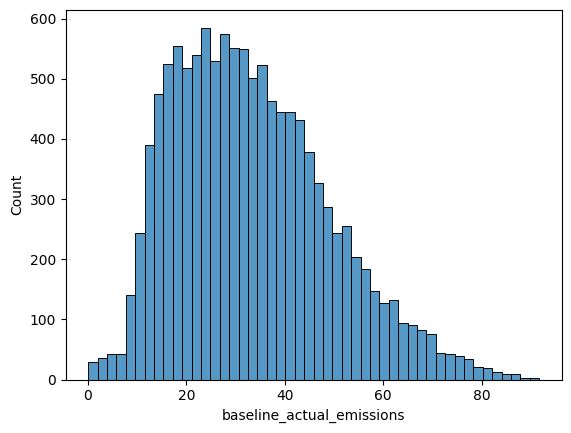

In [9]:
sns.histplot(synth_data['baseline_actual_emissions'])

## MOER - Simple Optimization - Forecast Emissions

In [10]:
synth_data['charger_simple_forecast']= synth_data.apply(
    lambda x: efu.get_schedule_and_cost(
        x.MWh_fraction,
        x.charged_kWh_actual / 1000,
        math.ceil(x.total_intervals_plugged_in), # will throw an error if the plug in time is too shart to reach full charge, should soften to a warning
        x.moer_data,
        asap = False
        ), 
        axis = 1
        )

synth_data['simple_charing_schedule'] = synth_data['charger_simple_forecast'].apply(
    lambda  x: x.get_schedule()
    )

synth_data['simple_estimated_emissions'] = synth_data['charger_simple_forecast'].apply(
    lambda  x: x.get_total_cost()
    )

In [11]:
def get_total_emission(moer, schedule): 
    x = np.array(schedule).flatten()
    return np.dot(moer[:x.shape[0]], x)

In [12]:
synth_data["simple_actual_emissions"] = synth_data.apply(
    lambda x: get_total_emission(
        x.moer_data_actual['value'],
        x.simple_charing_schedule,
    ),
    axis = 1
)

<Axes: xlabel='baseline_actual_emissions', ylabel='Count'>

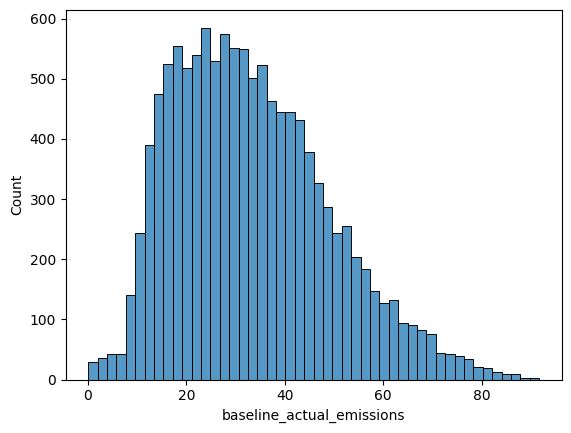

In [13]:
sns.histplot(synth_data["baseline_actual_emissions"])

<Axes: xlabel='simple_actual_emissions', ylabel='Count'>

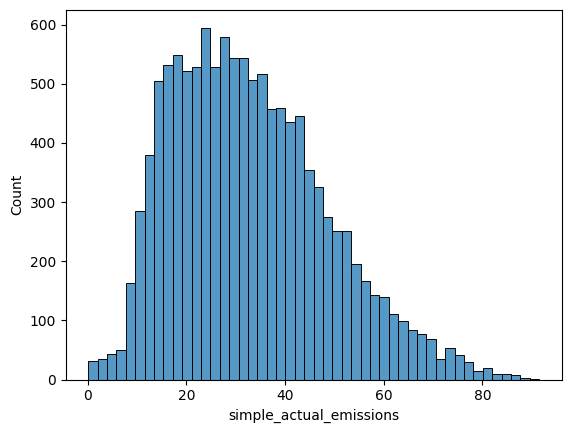

In [14]:
sns.histplot(synth_data["simple_actual_emissions"])

In [15]:
synth_data["simple_optimization_difference"] = synth_data["simple_actual_emissions"] - synth_data["baseline_actual_emissions"]

In [16]:
synth_data["success_rate"] = synth_data["simple_optimization_difference"] < 0

In [17]:
synth_data["success_rate"].value_counts()

success_rate
True     7825
False    4175
Name: count, dtype: int64